In [1]:
import numpy as np
import pandas as pd
import os
import time
import pickle
import gzip

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
%matplotlib inline

from sklearn.metrics import accuracy_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Fashion MNIST dataset
- 28*28 pixels(784 차원)
- label
  - 0 T-shirt/top
  - 1 Trouser
  - 2 Pullover
  - 3 Dress
  - 4 Coat
  - 5 Sandal
  - 6 Shirt
  - 7 Sneaker
  - 8 Bag
  - 9 Ankle boot


In [2]:
#데이터 불러오기
fashion=pd.read_csv('fashion-mnist.csv') #경로수정
fashion.head(3) #60000 rows

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0


- (Q1) X_train, y_train, X_test, y_test 지정하기
  - 60000개의 전체 데이터셋 사용하지 않아도 됨 (학습 속도가 느려짐)
  - 본인이 생각하는 적절한 train 개수, test 개수를 설정하여 분리하도록
    - 이때 train과 test 데이터의 라벨 분포가 균등하게 이루어지도록 분리해야함(학습시에 편향되지 않도록)
    - 그래프 그려서 라벨값 분포가 균등한지 확인할 것

In [8]:
#dataframe 섞기
fashion_rd=fashion.sample(frac=1)
fashion_rd=fashion_rd.sample(frac=1).reset_index(drop=True)
fashion_rd

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,8,0,0,0,0,0,0,0,0,0,...,173,168,178,86,0,0,0,0,0,0
1,3,0,0,0,0,0,0,0,0,0,...,136,100,0,0,1,0,0,0,0,0
2,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6,0,0,0,0,0,0,0,0,1,...,23,0,0,0,175,114,76,0,0,0
4,3,0,0,0,0,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,3,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0
59996,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59997,5,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,8,0,122,130,0
59998,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,5,0


In [10]:
#train data : 6000개 / test data : 1500개
fashion_rd_train=fashion_rd.loc[:5999,:]
fashion_rd_test=fashion_rd.loc[10000:11499,:]

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


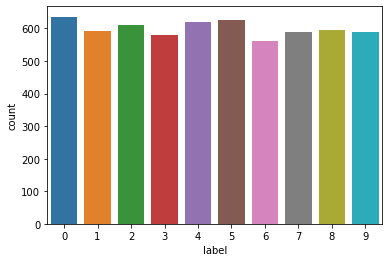

In [13]:
#train data
X_train=fashion_rd_train.iloc[:,1:]
y_train=fashion_rd_train['label']

sns.countplot(y_train) 
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


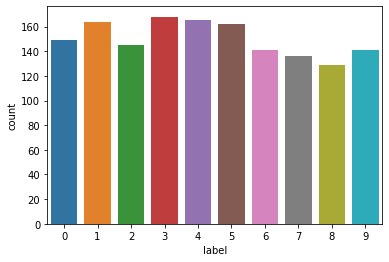

In [14]:
#test data
X_test=fashion_rd_test.iloc[:,1:]
y_test=fashion_rd_test['label']

sns.countplot(y_test) 
plt.show()

- 어떻게 생긴 데이터셋인지 확인해보기

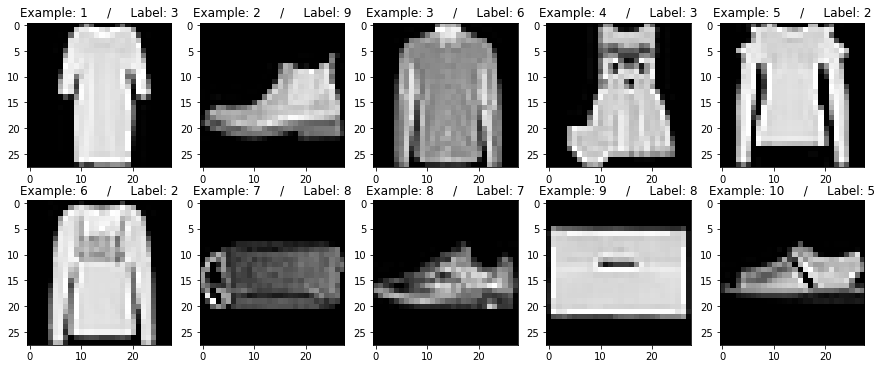

In [15]:
plt.figure(figsize=(15,6))
for i in range(1,11):
    plt.subplot(2,5,i)
    label = y_train.loc[i]
    image = X_train.loc[i,:].values.reshape([28, 28])
    plt.imshow(image, cmap=plt.get_cmap('gray'))
    plt.title('Example: %d     /     Label: %d'%(i, label))

plt.show()

# PCA를 활용해 성능 높여보기


- (Q2) 합리적인 잠재변수 개수 설정하기
  - PCA에서 각 잠재변수가 설명하는 분산 비율을 보고 적절한 잠재변수 개수 설정
  - 개수 설정 기준은 본인 재량. 다만, 명확한 기준을 서술할 것.

In [16]:
from sklearn.decomposition import PCA
pca=PCA(n_components=784)
X_train_PCA=pca.fit_transform(X_train)
X_train_PCA.shape 

(6000, 784)

In [17]:
pca.explained_variance_ratio_[:10]

array([0.29359853, 0.17511837, 0.05849375, 0.05063393, 0.03716314,
       0.03504962, 0.02291253, 0.01917879, 0.01336727, 0.01296167])

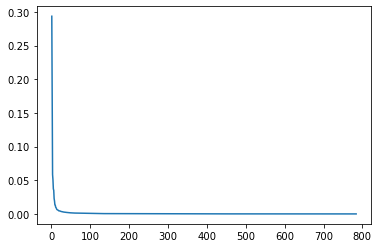

In [18]:
plt.plot(range(1,785),pca.explained_variance_ratio_)
plt.show() 

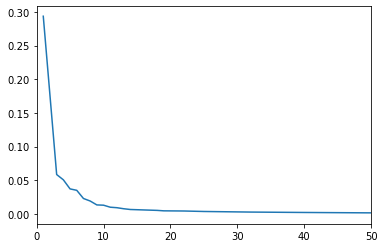

In [19]:
plt.plot(range(1,785),pca.explained_variance_ratio_)
plt.xlim(0,50)
plt.show()

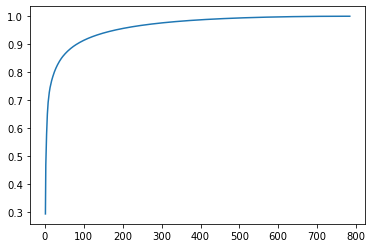

In [20]:
cumulative = []
temp = 0
for i in range(0, 784):
    temp += pca.explained_variance_ratio_[i]
    cumulative.append(temp)

plt.plot(range(1,785),cumulative)
plt.show()

In [21]:
for i in [10,20,50,100,784]:
  explained=np.sum(pca.explained_variance_ratio_[:i])
  print(i,'개의 잠재변수가 설명하는 분산은 전체 데이터의 {:.2f}%'.format(explained*100))

10 개의 잠재변수가 설명하는 분산은 전체 데이터의 71.85%
20 개의 잠재변수가 설명하는 분산은 전체 데이터의 78.42%
50 개의 잠재변수가 설명하는 분산은 전체 데이터의 86.34%
100 개의 잠재변수가 설명하는 분산은 전체 데이터의 91.42%
784 개의 잠재변수가 설명하는 분산은 전체 데이터의 100.00%


In [23]:
#90%의 설명이상을 설명해주는 데이터의 수 : 81
cumulative=np.array(cumulative)
np.where(cumulative>0.9)[0][0]

81

- (Q3) 학습속도, 성능의 향상을 보이는지 확인
  - 기존에 배웠던 여러가지 classification model들 활용하기
  - 최소한 1가지 이상의 모델에 대해 비교해보고 차원축소 이전, 이후 어떠한 차이를 보이는지 서술


In [24]:
#81차원으로 축소
pca=PCA(n_components=81)
X_train_PCA=pca.fit_transform(X_train) 
X_test_PCA=pca.transform(X_test)      
print('Original space:',X_train.shape)
print('After PCA:',X_train_PCA.shape)

Original space: (6000, 784)
After PCA: (6000, 81)


### 1. logictic regression

In [25]:
#기존 데이터
start=time.time()
logistic_original=LogisticRegression(max_iter=2000) #warning 메시지가 나와서 max_iter 지정해줌
logistic_original.fit(X_train,y_train)  #train set만 고려
print('train accuracy:',accuracy_score(y_train, logistic_original.predict(X_train)))
print('test accuracy:',accuracy_score(y_test, logistic_original.predict(X_test)))
print(f'{time.time()-start:.4f}sec')

train accuracy: 1.0
test accuracy: 0.7766666666666666
23.9527sec


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [26]:
#차원 축소 진행 : 81차원
start=time.time()
logistic_pca=LogisticRegression(max_iter=1000) 
logistic_pca.fit(X_train_PCA,y_train)
print('train accuracy:',accuracy_score(y_train, logistic_pca.predict(X_train_PCA)))
print('test accuracy:',accuracy_score(y_test, logistic_pca.predict(X_test_PCA)))
print(f'{time.time()-start:.4f}sec')

train accuracy: 0.8636666666666667
test accuracy: 0.8313333333333334
3.6857sec


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


- PCA 이후 학습 속도가 약 8배 정도 개선
- train accuracy는 감소. test accuracy는 소폭 증가.

### 2. Random Forest

In [27]:
#차원축소 이전(784차원)
start=time.time()
rf_original=RandomForestClassifier()
rf_original.fit(X_train,y_train)
print('train accuracy:',accuracy_score(y_train, rf_original.predict(X_train)))
print('test accuracy:',accuracy_score(y_test, rf_original.predict(X_test)))
print(f'{time.time()-start:.4f}sec')

train accuracy: 1.0
test accuracy: 0.8446666666666667
5.6081sec


In [28]:
#차원축소 이후(81차원)
start=time.time()
rf_pca=RandomForestClassifier()
rf_pca.fit(X_train_PCA, y_train)
print('train accuracy:',accuracy_score(y_train, rf_pca.predict(X_train_PCA)))
print('test accuracy:',accuracy_score(y_test, rf_pca.predict(X_test_PCA)))
print(f'{time.time()-start:.4f}sec')

train accuracy: 1.0
test accuracy: 0.84
4.1821sec


- 차원축소 이후 학습속도 1초 감소
- accuracy는 별다른 차이 없음

### 3.XGBoost

In [29]:
#차원축소 이전
from xgboost import XGBClassifier
start=time.time()
xgboost_original = XGBClassifier()
xgboost_original.fit(X_train, y_train)
print('train accuracy:',accuracy_score(y_train, xgboost_original.predict(X_train)))
print('test accuracy:',accuracy_score(y_test, xgboost_original.predict(X_test)))
print(f'{time.time()-start:.4f}sec')

train accuracy: 1.0
test accuracy: 0.86
51.6534sec


In [30]:
#차원축소 이후
start=time.time()
xgboost_pca = XGBClassifier()
xgboost_pca.fit(X_train_PCA, y_train)
print('train accuracy:',accuracy_score(y_train, xgboost_pca.predict(X_train_PCA)))
print('test accuracy:',accuracy_score(y_test, xgboost_pca.predict(X_test_PCA)))
print(f'{time.time()-start:.4f}sec')

train accuracy: 1.0
test accuracy: 0.8453333333333334
21.1222sec


- 차원 축소 이후 학습속도 감소
- accuracy는 비슷함

# 2차원으로 시각화
- (Q4) 여러가지 차원 축소 방법 중 적절할 것으로 예상되는 방법 최소한 3가지 이용해서 시각화해보기
  - 하나의 차원 축소 방법도 하이퍼파라미터의 설정 다양하게 해보기
  - ex) KPCA에서 다양한 커널 함수 사용, ISOMAP or LLE에서 고려할 이웃의 개수 변경해보기

### PCA

In [31]:
start=time.time()
pca=PCA(n_components=2)
X_train_PCA=pca.fit_transform(X_train) 
print(f'{time.time()-start:.4f}sec')

0.1446sec


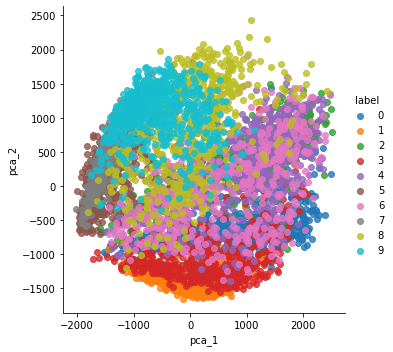

In [32]:
X_train_pca=pd.DataFrame(X_train_PCA).loc[:,0:1]
X_train_pca=pd.concat((X_train_pca, y_train), axis=1) 
X_train_pca.columns=['pca_1', 'pca_2', 'label']

sns.lmplot(x='pca_1',y='pca_2',data=X_train_pca,hue='label',fit_reg=False)
plt.show()

###  LDA

In [33]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
start=time.time()
lda = LinearDiscriminantAnalysis(n_components=2)
X_train_lda = lda.fit_transform(X_train, y_train)
print(f'{time.time()-start:.4f}sec')

0.8967sec


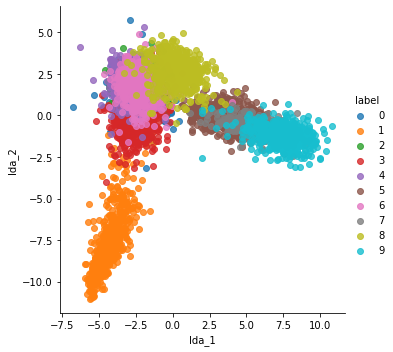

In [34]:
X_train_lda=pd.DataFrame(X_train_lda).loc[:,0:1]
X_train_lda=pd.concat((X_train_lda, y_train), axis=1) 
X_train_lda.columns=['lda_1', 'lda_2', 'label']
X_train_lda

sns.lmplot(x='lda_1',y='lda_2',data=X_train_lda,hue='label',fit_reg=False)
plt.show()

### KPCA

In [35]:
from sklearn.decomposition import KernelPCA

In [36]:
#커널함수 : rbf
start=time.time()
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True) #방사형 커널 사용
X_train_rbf_pca=rbf_pca.fit_transform(X_train)
print(f'{time.time()-start:.4f}sec')

8.2104sec


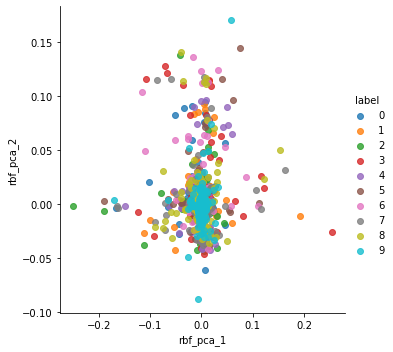

In [37]:
X_train_rbf_pca=pd.DataFrame(X_train_rbf_pca).loc[:,0:1]
X_train_rbf_pca=pd.concat((X_train_rbf_pca, y_train), axis=1) 
X_train_rbf_pca.columns=['rbf_pca_1', 'rbf_pca_2', 'label']

sns.lmplot(x='rbf_pca_1',y='rbf_pca_2',data=X_train_rbf_pca,hue='label',fit_reg=False)
plt.show()

In [38]:
#커널함수 : sigmoid
start=time.time()
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True) #시그모이드 커널 사용
X_train_sig_pca=sig_pca.fit_transform(X_train)
#X_test_rbf_pca=sig_pca.fit_transform(X_test)
print(f'{time.time()-start:.4f}sec')

6.5262sec


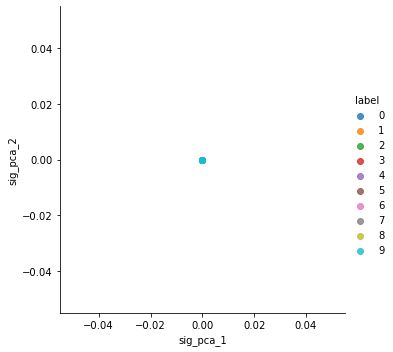

In [39]:
X_train_sig_pca=pd.DataFrame(X_train_sig_pca).loc[:,0:1]
X_train_sig_pca=pd.concat((X_train_sig_pca, y_train), axis=1) 
X_train_sig_pca.columns=['sig_pca_1', 'sig_pca_2', 'label']

sns.lmplot(x='sig_pca_1',y='sig_pca_2',data=X_train_sig_pca,hue='label',fit_reg=False)
plt.show()

### ISOMAP

In [40]:
#이웃 수=5
from sklearn.manifold import Isomap
start=time.time()
isomap=Isomap(n_neighbors=5,n_components=2,n_jobs=4)         
X_train_isomap=isomap.fit_transform(X_train)
print(f'{time.time()-start:.4f}sec')

22.6838sec


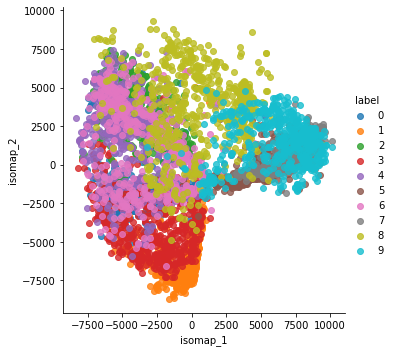

In [41]:
X_train_isomap=pd.DataFrame(X_train_isomap).loc[:,0:1]
X_train_isomap=pd.concat((X_train_isomap, y_train), axis=1) 
X_train_isomap.columns=['isomap_1', 'isomap_2', 'label']

sns.lmplot(x='isomap_1',y='isomap_2',data=X_train_isomap,hue='label',fit_reg=False)
plt.show()

In [42]:
#이웃 수=10
from sklearn.manifold import Isomap
start=time.time()
isomap=Isomap(n_neighbors=10,n_components=2,n_jobs=4)         
X_train_isomap10=isomap.fit_transform(X_train)
print(f'{time.time()-start:.4f}sec')

26.8190sec


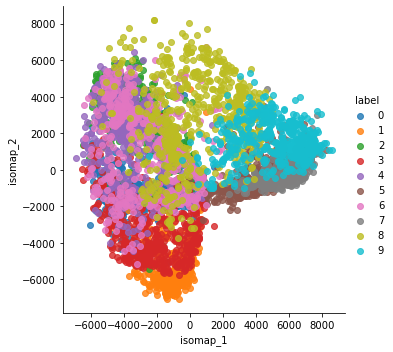

In [43]:
X_train_isomap10=pd.DataFrame(X_train_isomap10).loc[:,0:1]
X_train_isomap10=pd.concat((X_train_isomap10, y_train), axis=1) 
X_train_isomap10.columns=['isomap_1', 'isomap_2', 'label']

sns.lmplot(x='isomap_1',y='isomap_2',data=X_train_isomap10,hue='label',fit_reg=False)
plt.show()

### LLE

In [44]:
from sklearn.manifold import LocallyLinearEmbedding
start=time.time()
lle = LocallyLinearEmbedding(n_components=2, random_state=80)
X_train_lle = lle.fit_transform(X_train)
#X_test_lle=lle.transform(X_test)
print(f'{time.time()-start:.4f}sec')

2.3023sec


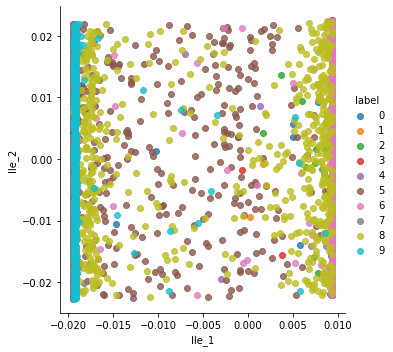

In [45]:
X_train_lle=pd.DataFrame(X_train_lle).loc[:,0:1]
X_train_lle=pd.concat((X_train_lle, y_train), axis=1) 
X_train_lle.columns=['lle_1', 'lle_2', 'label']
X_train_lle

sns.lmplot(x='lle_1',y='lle_2',data=X_train_lle,hue='label',fit_reg=False)
plt.show()

### t-SNE

In [46]:
from sklearn.manifold import TSNE
start=time.time()
tsne = TSNE(n_components=2, random_state=80) 
X_train_tsne = tsne.fit_transform(X_train)
print(f'{time.time()-start:.4f}sec')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


30.1165sec


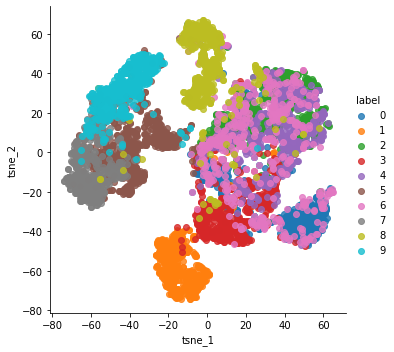

In [47]:
X_train_tsne=pd.DataFrame(X_train_tsne).loc[:,0:1]
X_train_tsne=pd.concat((X_train_tsne, y_train), axis=1) 
X_train_tsne.columns=['tsne_1', 'tsne_2', 'label']
X_train_tsne

sns.lmplot(x='tsne_1',y='tsne_2',data=X_train_tsne,hue='label',fit_reg=False)
plt.show()

- (Q5) 시도해본 차원축소 방법 중 Fashion MNIST 데이터셋을 가장 잘 시각화하는 것으로 보이는 방법은 무엇인지 서술해보자.

#### PCA, LDA, KCPA, ISOMAP, LLE, t-SNE를 각각 사용하여 시각화를 진행해보았는데, PCA, LDA,  ISOMAP, t-SNE에서의 결과가 시각화를 잘 나타내었다.

- (Q6) 저차원에서 제대로 분류가 잘 되지 않는 라벨은 무엇인지 언급해보고, 왜 제대로 분류되지 않을 것인지 추측해보자.

라벨 4의 분류가 상대적으로 잘 되지 않았는데, 특히 PCA 시각화 결과에서 그러하였다. PCA는 잠재변수의 분산을 크게 만드는 선형결합 계수들을 구하는 방식으로 수행되는데, 라벨4의 경우, 분산이 별로 크게 나오지 않아서 그랬을 것 같다.

수고하셨습니다~